X_train shape: (1078, 80)
X_val shape: (359, 80)
X_test shape: (360, 80)
Input shape: (3, 8, 8)
Output shape after first layer: (3, 5, 5)
Output shape after second layer: (9, 3, 3)
Cross entropy Loss: 4911.31
F1 Score on Validation Set: 0.10
F1 Score on Test Set: 0.10


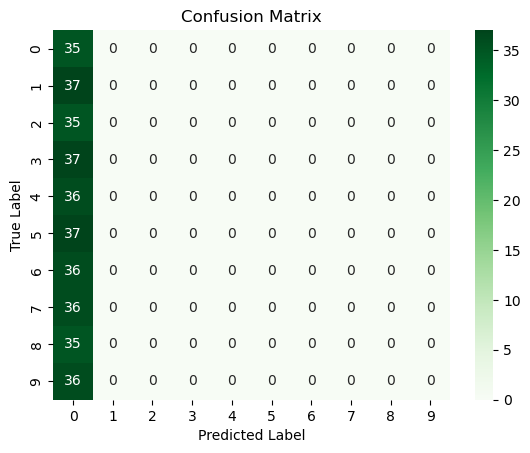

In [11]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load the digits dataset from scikit-learn
digits = datasets.load_digits()

# Flatten the 8x8 images into 1D arrays
data = digits.images.reshape((len(digits.images), -1))

# Add padding with the size 8 to each side
data_padded = np.pad(data, ((0, 0), (8, 8)), mode='constant')

# Split the dataset into train, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    data_padded, digits.target, test_size=0.4, stratify=digits.target, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

def convolution(input_volume, kernel, bias):
    num_channels, input_height, input_width = input_volume.shape
    num_filters, kernel_height, kernel_width = kernel.shape

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    output = np.zeros((num_filters, output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            for k in range(num_filters):
                output[k, i, j] = np.sum(input_volume[:, i:i+kernel_height, j:j+kernel_width] * kernel[k, :, :])

            # Corrected: Add bias term for each channel
            output[:, i, j] += bias.flatten()

    return output


def relu(x):
    #ReLU activation function
    return np.maximum(0, x)

def initialize_parameters(num_input_channels, num_output_channels, kernel_size):
    

    #Returns kernel: Initialized kernel weights bias: Initialized bias term
   
    kernel = np.random.randn(num_output_channels, kernel_size, kernel_size) / np.sqrt(num_input_channels)
    bias = np.zeros((num_output_channels, 1, 1))

    return kernel, bias

def convolutional_layer(input_volume, num_output_channels, kernel_size, activation_function=relu):
    
    #Returns output: Output volume after convolution and activation, parameters: Dictionary containing kernel and bias
    
    num_input_channels, _, _ = input_volume.shape
    kernel, bias = initialize_parameters(num_input_channels, num_output_channels, kernel_size)
    output = convolution(input_volume, kernel, bias)
    output = activation_function(output)

    parameters = {'kernel': kernel, 'bias': bias}

    return output, parameters

def linear_activation(x):
    return x

def sigmoid_activation(x):
    x = np.clip(x, -500, 500)  # Limit x to a reasonable range to avoid overflow
    return 1 / (1 + np.exp(-x))

def relu_activation(x):
    return np.maximum(0, x)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Softmax activation for multiclass classification
def softmax_activation(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# One-hot encoding
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

# Forward pass through a fully connected layer
def fully_connected_layer(input_data, weights, bias, activation_function):
    return activation_function(np.dot(input_data, weights) + bias)

# Backward pass through a fully connected layer
def fully_connected_backward(dA, A_prev, weights, bias, activation_derivative):
    m = A_prev.shape[0]

    dZ = dA * activation_derivative
    dW = np.dot(A_prev.T, dZ) / m
    db = np.sum(dZ, axis=0, keepdims=True) / m
    dA_prev = np.dot(dZ, weights.T)

    return dA_prev, dW, db

# Forward pass through the network
def forward_pass(X, parameters, activation_functions):
    A = X
    caches = []
    for i in range(len(parameters) // 2):
        W = parameters[f'W{i+1}']
        b = parameters[f'b{i+1}']
        activation_function = activation_functions[i]

        A_prev = A
        A = fully_connected_layer(A_prev, W, b, activation_function)

        cache = (A_prev, W, b, A)
        caches.append(cache)

    return A, caches

# Backward pass through the network
def backward_pass(AL, Y, caches, activation_derivatives):
    grads = {}
    #Get the number of examples in the training set
    m = AL.shape[0]
    # Reshape true labels Y to match the shape of the predicted probabilities AL
    Y = Y.reshape(AL.shape)
    # Compute the derivative of the cost function with respect to the output layer activations (dAL)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Backward pass through the output layer
    # Get the gradients for the output layer (last layer)
    current_cache = caches[-1]
    grads[f'dA{len(caches)}'], grads[f'dW{len(caches)}'], grads[f'db{len(caches)}'] = fully_connected_backward(
        dAL, current_cache[0], current_cache[1], current_cache[2], activation_derivatives[-1](current_cache[3]))
    # Loop through the remaining layers in reverse order (excluding the output layer)
    for i in reversed(range(len(caches) - 1)):
        # Get the gradients for the current layer
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = fully_connected_backward(
            grads[f'dA{i+2}'], current_cache[0], current_cache[1], current_cache[2], activation_derivatives[i](current_cache[3]))
        # Store the gradients for the current layer in the grads dictionary
        grads[f'dA{i+1}'] = dA_prev_temp
        grads[f'dW{i+1}'] = dW_temp
        grads[f'db{i+1}'] = db_temp

    return grads

# Function to update parameters using SGD
def update_parameters(parameters, grads, learning_rate, lambda_reg):
    for i in range(len(parameters) // 2):
        # Update weights with gradient descent and L2 regularization
        parameters[f'W{i+1}'] -= learning_rate * (grads[f'dW{i+1}'] + lambda_reg * parameters[f'W{i+1}'])
        # Update biases with gradient descent
        parameters[f'b{i+1}'] -= learning_rate * grads[f'db{i+1}']

    return parameters
# Function to train the neural network model
def train_model(X_train, y_train, X_val, y_val, num_epochs, learning_rate, activation_functions, activation_derivatives, lambda_reg):
    num_input_features = X_train.shape[1]
    num_output_classes = 80

    # Initialize parameters (weights and biases)
    parameters = {}
    costs = []
    validation_costs = []
    # Initialize weights and biases for each layer
    for i in range(1, 3):
        parameters[f'W{i}'] = np.random.randn(num_input_features, num_input_features) / np.sqrt(num_input_features)
        parameters[f'b{i}'] = np.zeros((1, num_input_features))

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        AL, caches = forward_pass(X_train, parameters, activation_functions)

        # One-hot encode the true labels with the correct number of classes
        y_one_hot = one_hot_encode(y_train, num_output_classes)

        # Compute cost (cross-entropy loss) with L2 regularization
        cost = cross_entropy_loss(y_one_hot, softmax_activation(AL))
        costs.append(cost)

        # Backward pass
        grads = backward_pass(softmax_activation(AL), y_one_hot, caches, activation_derivatives)

        # Update parameters with L2 regularization
        parameters = update_parameters(parameters, grads, learning_rate, lambda_reg)

    return parameters, cost

#Adjustng hyperparameters such as num_epochs and learning_rate based on your specific case
num_epochs = 100
learning_rate = 0.01
lambda_reg = 0.01  # Add this line to define lambda_reg

# Example usage
input_channels = 3  # Number of input channels
input_height = 8
input_width = 8
input_volume = np.random.randn(input_channels, input_height, input_width)

# First convolutional layer
output_channels1 = 3
kernel_size1 = 4
output1, params1 = convolutional_layer(input_volume, output_channels1, kernel_size1)

# Second convolutional layer
output_channels2 = 3 * output_channels1  # 3 new output channels per one input channel
kernel_size2 = 3
output2, params2 = convolutional_layer(output1, output_channels2, kernel_size2)

# Print shapes of outputs
print("Input shape:", input_volume.shape)
print("Output shape after first layer:", output1.shape)
print("Output shape after second layer:", output2.shape)

# Define activation functions and their derivatives
activation_functions = [relu_activation, sigmoid_activation]
activation_derivatives = [lambda x: (x > 0).astype(float), lambda x: sigmoid_activation(x) * (1 - sigmoid_activation(x))]

# Train the model
trained_parameters, costs = train_model(X_train, y_train, X_val, y_val, num_epochs, learning_rate, activation_functions, activation_derivatives, lambda_reg)
# Evaluate on validation set after training
val_predictions, _ = forward_pass(X_val, trained_parameters, activation_functions)
val_predictions = softmax_activation(val_predictions)
val_predictions = np.argmax(val_predictions, axis=1)

f1 = f1_score(y_val, val_predictions, average='micro')
cm = confusion_matrix(y_val, val_predictions)

# Evaluate on test set after training
test_predictions, _ = forward_pass(X_test, trained_parameters, activation_functions)
test_predictions = softmax_activation(test_predictions)
test_predictions = np.argmax(test_predictions, axis=1)
f1_test = f1_score(y_test, test_predictions, average='micro')
cm_test = confusion_matrix(y_test, test_predictions)
# Print performance metrics
print(f"Cross entropy Loss: {costs:.2f}")
print(f"F1 Score on Validation Set: {f1:.2f}")
print(f"F1 Score on Test Set: {f1_test:.2f}")
# Plot confusion matrix
plt.plot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

